In [468]:
###### import argparse
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

import torch.nn.utils.spectral_norm as spectralnorm
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from models import *
from utils import *
from helper import *

device = torch.device('cuda' if torch.cuda.is_available else cpu)

!nvidia-smi

Mon Mar 25 15:32:55 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:2F:00.0 Off |                    0 |
| N/A   48C    P0    30W /  70W |   3043MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def plot_img_series(x_1,x_2,x_1_hat,x_2_hat_JD, x_2_hat_NEW,x_2_hat_FMD, bitrate ,letter):
    fig, axarr = plt.subplots(4,2)
    fig.set_size_inches(10, 15)

    axarr[0,1].axis('off')
    axarr[0,0].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')
    axarr[3,0].axis('off')
    axarr[3,1].axis('off')


    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[1,0].set_title(r"$\hat{X}_1$ - 12 bits")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JOINT$ - " + f'{bitrate} bits')
    axarr[2,0].set_title(r"$\hat{X}_1$  - 12 bits")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-FMD$ - "  + f'{bitrate} bits')
    axarr[3,0].set_title(r"$\hat{X}_1$  - 12 bits")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-NEW$ - "  + f'{bitrate} bits')

    axarr[0,0].imshow(x_1.cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.cpu().data.numpy(),cmap = 'gray')
    axarr[1,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_JD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_FMD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,1].imshow(x_2_hat_NEW.squeeze().cpu().data.numpy(),cmap = 'gray')
    '''
    plt.imsave(f"./reconstructions/x1{letter}.png", x_1.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}.png", x_2.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x1{letter}_hat_12.png",x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}_JD_{bitrate}.png", x_2_hat_JD.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}_FMD_{bitrate}.png", x_2_hat_FMD.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}_NEW_{bitrate}.png", x_2_hat_NEW.squeeze().cpu().data.numpy(),cmap = 'gray')
    '''

Finished Loading MNIST!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


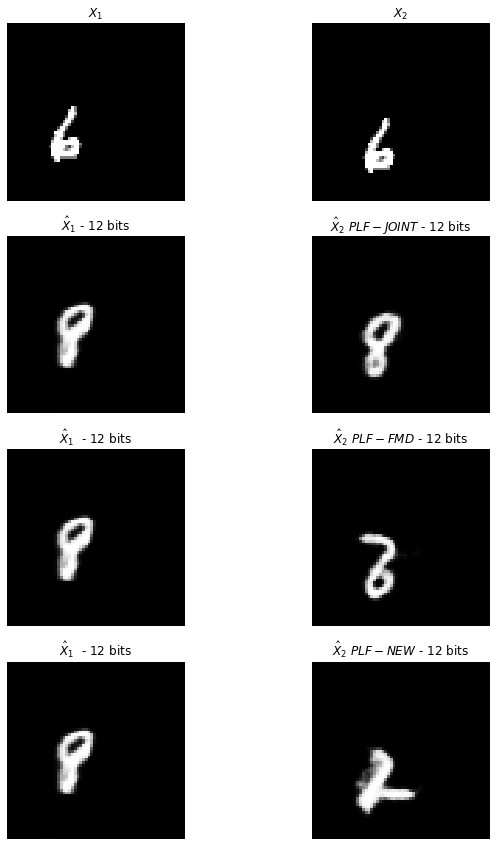

In [3]:
def compare_models(z_dim =1,lambda_ = 0.0 , bitrate = 12, letter = 'a'):
    # path to load trained models from
    pre_path_NEW = f'./saved_models/R1-eps/{bitrate}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{lambda_}|lambdaMSE_1.0'
    

    pre_path_JD = f'./saved_models/R1-eps/{bitrate}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    
    pre_path_FMD = f'./saved_models/R1-eps/{bitrate}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'


    # load MMNIST
    train_loader, test_loader = get_dataloader(data_root='./data/', seq_len=8, batch_size=64, num_digits=1)

    # load fixed encoder for first frame
    device = torch.device('cuda' if torch.cuda.is_available else cpu)
    I_dim = 12 
    I_L = 2
    encoder = Encoder(dim=I_dim, nc=1, stochastic=True, quantize_latents=True, L=I_L).to(device).eval() 
    decoder = Decoder_Iframe(dim=I_dim).to(device).eval()
    decoder_hat = Decoder_Iframe(dim=I_dim).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #load ssf models for second frame

    # NEW
    ssf_NEW = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_NEW.motion_encoder.load_state_dict(torch.load(pre_path_NEW+'/m_enc.pth'))
    ssf_NEW.motion_decoder.load_state_dict(torch.load(pre_path_NEW+'/m_dec.pth'))
    ssf_NEW.P_encoder.load_state_dict(torch.load(pre_path_NEW+'/p_enc.pth'))
    ssf_NEW.res_encoder.load_state_dict(torch.load(pre_path_NEW+'/r_enc.pth'))
    ssf_NEW.res_decoder.load_state_dict(torch.load(pre_path_NEW+'/r_dec.pth'))

    # JD
    ssf_JD = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD.motion_encoder.load_state_dict(torch.load(pre_path_JD+'/m_enc.pth'))
    ssf_JD.motion_decoder.load_state_dict(torch.load(pre_path_JD+'/m_dec.pth'))
    ssf_JD.P_encoder.load_state_dict(torch.load(pre_path_JD+'/p_enc.pth'))
    ssf_JD.res_encoder.load_state_dict(torch.load(pre_path_JD+'/r_enc.pth'))
    ssf_JD.res_decoder.load_state_dict(torch.load(pre_path_JD+'/r_dec.pth'))
    
    # FMD
    ssf_FMD = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD.motion_encoder.load_state_dict(torch.load(pre_path_FMD+'/m_enc.pth'))
    ssf_FMD.motion_decoder.load_state_dict(torch.load(pre_path_FMD+'/m_dec.pth'))
    ssf_FMD.P_encoder.load_state_dict(torch.load(pre_path_FMD+'/p_enc.pth'))
    ssf_FMD.res_encoder.load_state_dict(torch.load(pre_path_FMD+'/r_enc.pth'))
    ssf_FMD.res_decoder.load_state_dict(torch.load(pre_path_FMD+'/r_dec.pth'))


    batch_index = torch.randint(64,(1,)).item()

    x = next(iter(test_loader))
    x = x.permute(0, 4, 1, 2, 3).to(device).float()

    # original frames
    x_1 = x[batch_index,0,0,:,:]
    x_2 = x[batch_index,0,1,:,:]

    hx = encoder(x[:,:,0,...])[0]
    x_ref = decoder(hx)
    print(x_ref.shape)
    print(x[:,:,0,...].shape)
    x_1_hat = decoder_hat(hx).detach()
    x_2_hat_JD = ssf_JD(x[:,:,1,...], x_ref, x_1_hat)
    x_2_hat_NEW = ssf_NEW(x[:,:,1,...], x_ref, x_1_hat)
    x_2_hat_FMD = ssf_FMD(x[:,:,1,...], x_ref, x_1_hat)

    plot_img_series(x_1, x_2,
                    x_1_hat[batch_index,0:,:], 
                    x_2_hat_JD[batch_index,0:,:], 
                    x_2_hat_NEW[batch_index,0:,:],
                    x_2_hat_FMD[batch_index,0:,:],
                   bitrate,
                   letter)



compare_models(z_dim = 6, lambda_ = 0.01 , bitrate = 12, letter = 'c')

Finished Loading MNIST!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


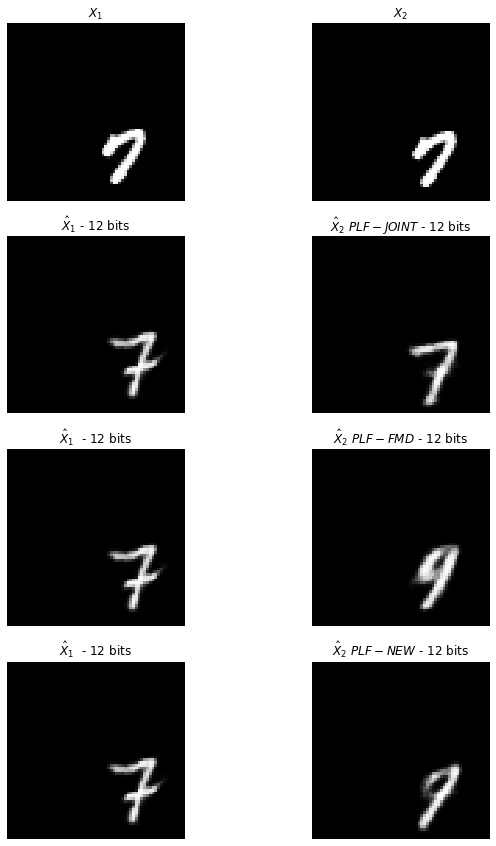

In [4]:
compare_models(z_dim = 6, lambda_ = 0.005 , bitrate = 12, letter = 'c')

In [212]:
def plot_or_plf(x_1,x_2,x_1_hat,x_2_hat, eps, PLF):
    fig, axarr = plt.subplots(2,2)
    fig.set_size_inches(10, 10)

    axarr[0,1].axis('off')
    axarr[0,0].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')



    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[1,0].set_title(r"$\hat{X}_1$ - 12 bits")
    axarr[1,1].set_title(r"$\hat{X}_2 ~"+ f" PLF-{PLF} - " + f'{eps} bits')

    axarr[0,0].imshow(x_1.cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.cpu().data.numpy(),cmap = 'gray')
    axarr[1,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat.squeeze().cpu().data.numpy(),cmap = 'gray')

    
    plt.imsave(f"./reconstructions/R1-eps/x1.png", x_1.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/R1-eps/x2.png", x_2.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/R1-eps/x1_hat_12.png",x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/R1-eps/x2_{PLF}_{eps}.png", x_2_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    
    

def compare_or_plf(x, PLF = 'NEW', eps = 12, lambda_ = 0.01, gen_x_1_hat = True, x_1_hat = None, x_ref = None):
    # path to load trained models from
    z_dim = eps//2
    
    if PLF =='NEW':
        pre_path = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{lambda_}|lambdaMSE_1.0'
    elif PLF =='JD':
        pre_path = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                    + f'lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    elif PLF =='FMD':
        pre_path = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'

    # load fixed encoder for first frame
    device = torch.device('cuda' if torch.cuda.is_available else cpu)
    if gen_x_1_hat:
        I_dim = 12 
        I_L = 2
        encoder = Encoder(dim=I_dim, nc=1, stochastic=True, quantize_latents=True, L=I_L).to(device).eval() 
        decoder = Decoder_Iframe(dim=I_dim).to(device).eval()
        decoder_hat = Decoder_Iframe(dim=I_dim).to(device).eval()
        encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
        decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
        decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #load ssf models for second frame

    # NEW
    ssf = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    ssf.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    ssf.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    ssf.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    ssf.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))

    # original frames
    x_1 = x[0,0,0,:,:]
    x_2 = x[0,0,1,:,:]
    if gen_x_1_hat:
        hx = encoder(x[:,:,0,...])[0]
        x_ref = decoder(hx)
        x_1_hat = decoder_hat(hx).detach()
    print(x_ref.shape, x_1_hat.shape, x[:,:,1,...].shape)
    x_2_hat = ssf(x[:,:,1,...], x_ref, x_1_hat)
    
    
    
    x_1_hat_ = x_1_hat[0,0:,:]    
    x_2_hat = x_2_hat[0,0:,:]
    
    plot_or_plf(x_1,x_2,x_1_hat_,x_2_hat, eps, PLF)
    
    return x_1_hat, x_ref

    

In [431]:
train_loader, test_loader = get_dataloader(data_root='./data/', seq_len=8, batch_size=64, num_digits=1)
x = next(iter(test_loader))
x = x.permute(0, 4, 1, 2, 3).to(device).float()


Finished Loading MNIST!


[-1.0, 1.0]
[-1.0, 1.0]
torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64])


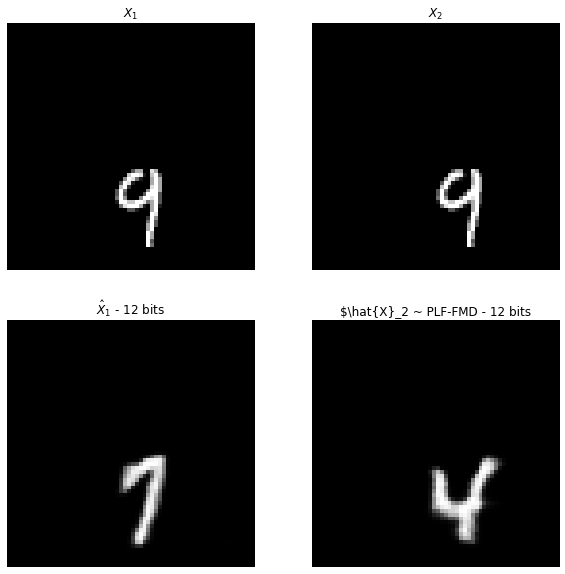

In [448]:
x1_hat, x_ref = compare_or_plf(x, PLF = 'FMD', eps = 12, lambda_ = 0.01, gen_x_1_hat = True, x_1_hat = x1_hat, x_ref = x_ref)

In [127]:
def plot_img_series_2(x_1,x_2,x_2_hat_JD, x_2_hat_NEW,x_2_hat_FMD, bitrate):
    fig, axarr = plt.subplots(4,3)
    fig.set_size_inches(10, 15)

    axarr[0,0].axis('off')
    axarr[0,1].axis('off')
    axarr[0,2].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[1,2].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')
    axarr[2,2].axis('off')
    axarr[3,0].axis('off')
    axarr[3,1].axis('off')
    axarr[3,2].axis('off')


    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[0,2].set_title("original trajectory")
    axarr[1,0].set_title(r"$X_1$ ")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JD$ - " + f'{bitrate} bits')
    axarr[1,2].set_title("JD trajectory")
    axarr[2,0].set_title(r"$X_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-FMD$ - "  + f'{bitrate} bits')
    axarr[2,2].set_title("FMD trajectory")
    axarr[3,0].set_title(r"$X_1$")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-NEW$ - "  + f'{bitrate} bits')
    axarr[3,2].set_title("NEW trajectory")

    or_t = x_1.squeeze().cpu().data.numpy() + x_2.squeeze().cpu().data.numpy()
    jd_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD.squeeze().cpu().data.numpy()
    fmd_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_FMD.squeeze().cpu().data.numpy()
    new_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_NEW.squeeze().cpu().data.numpy()
    
    or_t[or_t>1] = 1
    jd_t[jd_t>1] = 1
    fmd_t[fmd_t>1] = 1
    new_t[new_t>1] = 1
    
    axarr[0,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,2].imshow(or_t, cmap = 'gray')
    
    axarr[1,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_JD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,2].imshow(jd_t, cmap = 'gray')
    
    axarr[2,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_FMD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,2].imshow(fmd_t, cmap = 'gray')
    
    axarr[3,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,1].imshow(x_2_hat_NEW.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,2].imshow(new_t, cmap = 'gray')
    

In [482]:
def plot_img_series_jd(x_1,x_2,x_2_hat_JD1, x_2_hat_JD2,x_2_hat_JD3, bitrate):
    fig, axarr = plt.subplots(4,3)
    fig.set_size_inches(10, 15)

    axarr[0,0].axis('off')
    axarr[0,1].axis('off')
    axarr[0,2].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[1,2].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')
    axarr[2,2].axis('off')
    axarr[3,0].axis('off')
    axarr[3,1].axis('off')
    axarr[3,2].axis('off')


    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[0,2].set_title("original trajectory")
    axarr[1,0].set_title(r"$X_1$ ")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JD 1$ - " + f'{bitrate} bits')
    axarr[1,2].set_title("JD trajectory 1")
    axarr[2,0].set_title(r"$X_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-JD 2$ - "  + f'{bitrate} bits')
    axarr[2,2].set_title("JD trajectory 2")
    axarr[3,0].set_title(r"$X_1$")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-JD 3$ - "  + f'{bitrate} bits')
    axarr[3,2].set_title("JD trajectory 3")

    or_t = x_1.squeeze().cpu().data.numpy() + x_2.squeeze().cpu().data.numpy()
    jd1_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD1.squeeze().cpu().data.numpy()
    jd2_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD2.squeeze().cpu().data.numpy()
    jd3_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD3.squeeze().cpu().data.numpy()
    
    or_t[or_t>1] = 1
    jd1_t[jd1_t>1] = 1
    jd2_t[jd2_t>1] = 1
    jd3_t[jd3_t>1] = 1
    
    axarr[0,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,2].imshow(or_t, cmap = 'gray')
    
    axarr[1,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_JD1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,2].imshow(jd1_t, cmap = 'gray')
    
    axarr[2,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_JD2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,2].imshow(jd2_t, cmap = 'gray')
    
    axarr[3,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,1].imshow(x_2_hat_JD3.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,2].imshow(jd3_t, cmap = 'gray')



def compare_models_JD(lambda_ = 0.0 , eps = 2, x = 0, step =5):
    # path to load trained models from
    pre_path_NEW = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{lambda_}|lambdaMSE_1.0'
    pre_path_JD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    pre_path_FMD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'
    z_dim = eps//2
    #load ssf models for second frame
    
    
    # JD
    ssf_JD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD.motion_encoder.load_state_dict(torch.load(pre_path_JD+'/m_enc.pth'))
    ssf_JD.motion_decoder.load_state_dict(torch.load(pre_path_JD+'/m_dec.pth'))
    ssf_JD.P_encoder.load_state_dict(torch.load(pre_path_JD+'/p_enc.pth'))
    ssf_JD.res_encoder.load_state_dict(torch.load(pre_path_JD+'/r_enc.pth'))
    ssf_JD.res_decoder.load_state_dict(torch.load(pre_path_JD+'/r_dec.pth'))
    
    # original frames
    x_1 = x[:,:,0,...]
    x_2 = x[:,:,1,...]
    x_2_hat_JD1 = ssf_JD(x_2,x_1)
    x_2_hat_JD2 = ssf_JD(x_2,x_1)
    x_2_hat_JD3 = ssf_JD(x_2,x_1)

    plot_img_series_jd(x_1[batch_index],
                      x_2[batch_index], 
                    x_2_hat_JD1[batch_index,0:,:], 
                    x_2_hat_JD2[batch_index,0:,:],
                    x_2_hat_JD3[batch_index,0:,:],
                   eps)

In [504]:
def plot_img_series_FMD(x_1,x_2,x_2_hat_JD1, x_2_hat_JD2,x_2_hat_JD3, bitrate):
    fig, axarr = plt.subplots(4,3)
    fig.set_size_inches(10, 15)

    axarr[0,0].axis('off')
    axarr[0,1].axis('off')
    axarr[0,2].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[1,2].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')
    axarr[2,2].axis('off')
    axarr[3,0].axis('off')
    axarr[3,1].axis('off')
    axarr[3,2].axis('off')


    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[0,2].set_title("original trajectory")
    axarr[1,0].set_title(r"$X_1$ ")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-FMD 1$ - " + f'{bitrate} bits')
    axarr[1,2].set_title("JD trajectory 1")
    axarr[2,0].set_title(r"$X_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-FMD 2$ - "  + f'{bitrate} bits')
    axarr[2,2].set_title("JD trajectory 2")
    axarr[3,0].set_title(r"$X_1$")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-FMD 3$ - "  + f'{bitrate} bits')
    axarr[3,2].set_title("JD trajectory 3")

    or_t = x_1.squeeze().cpu().data.numpy() + x_2.squeeze().cpu().data.numpy()
    jd1_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD1.squeeze().cpu().data.numpy()
    jd2_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD2.squeeze().cpu().data.numpy()
    jd3_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD3.squeeze().cpu().data.numpy()
    
    or_t[or_t>1] = 1
    jd1_t[jd1_t>1] = 1
    jd2_t[jd2_t>1] = 1
    jd3_t[jd3_t>1] = 1
    
    axarr[0,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,2].imshow(or_t, cmap = 'gray')
    
    axarr[1,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_JD1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,2].imshow(jd1_t, cmap = 'gray')
    
    axarr[2,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_JD2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,2].imshow(jd2_t, cmap = 'gray')
    
    axarr[3,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,1].imshow(x_2_hat_JD3.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,2].imshow(jd3_t, cmap = 'gray')



def compare_models_FMD(lambda_ = 0.0 , eps = 2, x = 0, step =5):
    # path to load trained models from
    pre_path_FMD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'
    z_dim = eps//2
    #load ssf models for second frame
    
    
    # JD
    ssf_FMD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD.motion_encoder.load_state_dict(torch.load(pre_path_FMD+'/m_enc.pth'))
    ssf_FMD.motion_decoder.load_state_dict(torch.load(pre_path_FMD+'/m_dec.pth'))
    ssf_FMD.P_encoder.load_state_dict(torch.load(pre_path_FMD+'/p_enc.pth'))
    ssf_FMD.res_encoder.load_state_dict(torch.load(pre_path_FMD+'/r_enc.pth'))
    ssf_FMD.res_decoder.load_state_dict(torch.load(pre_path_FMD+'/r_dec.pth'))
    
    # original frames
    x_1 = x[:,:,0,...]
    x_2 = x[:,:,1,...]
    x_2_hat_FMD1 = ssf_FMD(x_2,x_1)
    x_2_hat_FMD2 = ssf_FMD(x_2,x_1)
    x_2_hat_FMD3 = ssf_FMD(x_2,x_1)

    plot_img_series_FMD(x_1[batch_index],
                      x_2[batch_index], 
                    x_2_hat_FMD1[batch_index,0:,:], 
                    x_2_hat_FMD2[batch_index,0:,:],
                    x_2_hat_FMD3[batch_index,0:,:],
                   eps)

Finished Loading MovingMNIST_l_custom_step!
torch.Size([64, 1, 8, 64, 64])
[-1.0, 1.0]


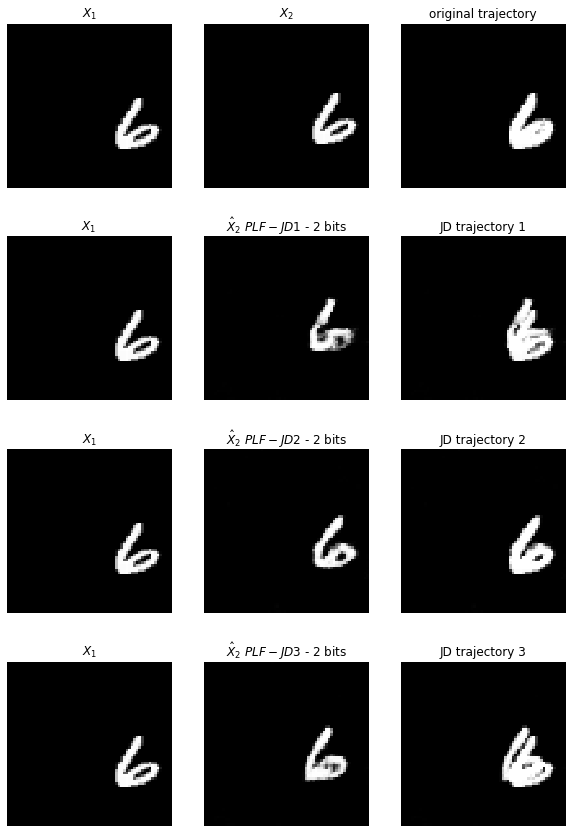

In [503]:
batch_index =  torch.randint(64,(1,)).item()
loader, test_loader = get_dataloader(data_root='./data/', dataset = 'mmnist_custom_step',step = 5, seq_len=8, batch_size=64, num_digits=1)
x1 = next(iter(loader))
x1 = x1.permute(0, 4, 1, 2, 3).to(device).float()
print(x1.shape)
compare_models_JD(lambda_ = 0.02 , eps = 2, x = x1, step =5)

[-1.0, 1.0]
[-1.0, 1.0]


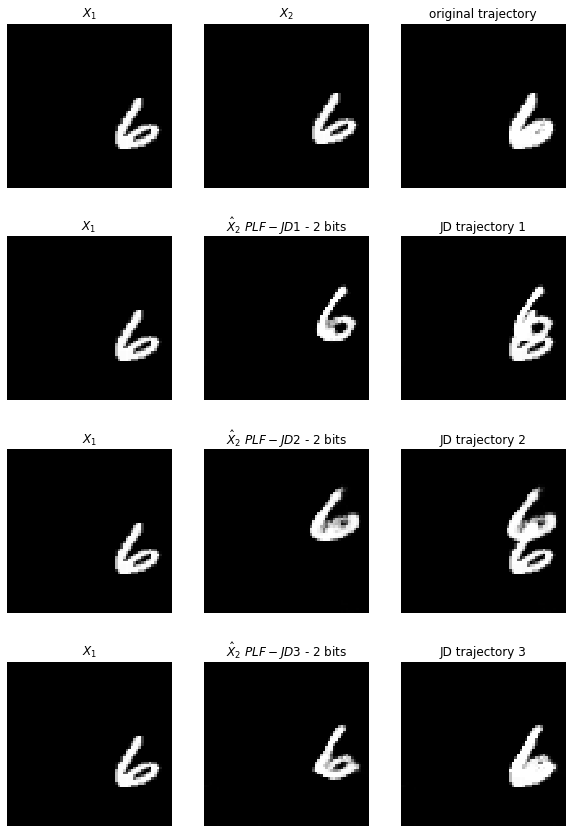

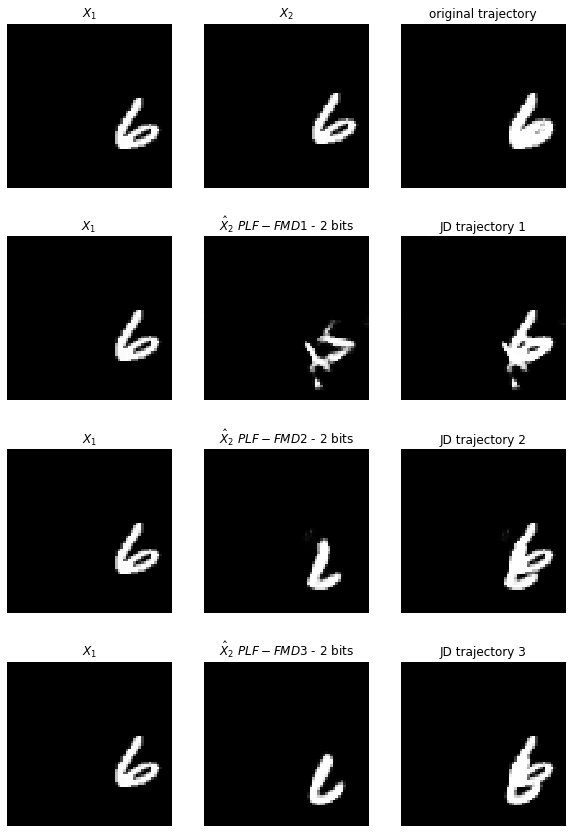

In [506]:
compare_models_JD(lambda_ = 0.02 , eps = 2, x = x1, step =15)
compare_models_FMD(lambda_ = 0.02 , eps = 2, x = x1, step =15)

In [232]:
def compare_models_2(lambda_ = 0.0 , eps = 2, x = 0,step=15, stochastic = True):
    # path to load trained models from
    pre_path_NEW = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{lambda_}|lambdaMSE_1.0'
    pre_path_JD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    pre_path_FMD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'
    z_dim = eps//2
    #load ssf models for second frame
    
    # NEW
    ssf_NEW = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=stochastic, quantize_latents=True, L=2).to(device).eval()
    ssf_NEW.motion_encoder.load_state_dict(torch.load(pre_path_NEW+'/m_enc.pth'))
    ssf_NEW.motion_decoder.load_state_dict(torch.load(pre_path_NEW+'/m_dec.pth'))
    ssf_NEW.P_encoder.load_state_dict(torch.load(pre_path_NEW+'/p_enc.pth'))
    ssf_NEW.res_encoder.load_state_dict(torch.load(pre_path_NEW+'/r_enc.pth'))
    ssf_NEW.res_decoder.load_state_dict(torch.load(pre_path_NEW+'/r_dec.pth'))

    # JD
    ssf_JD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD.motion_encoder.load_state_dict(torch.load(pre_path_JD+'/m_enc.pth'))
    ssf_JD.motion_decoder.load_state_dict(torch.load(pre_path_JD+'/m_dec.pth'))
    ssf_JD.P_encoder.load_state_dict(torch.load(pre_path_JD+'/p_enc.pth'))
    ssf_JD.res_encoder.load_state_dict(torch.load(pre_path_JD+'/r_enc.pth'))
    ssf_JD.res_decoder.load_state_dict(torch.load(pre_path_JD+'/r_dec.pth'))
    
    # FMD
    ssf_FMD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=stochastic, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD.motion_encoder.load_state_dict(torch.load(pre_path_FMD+'/m_enc.pth'))
    ssf_FMD.motion_decoder.load_state_dict(torch.load(pre_path_FMD+'/m_dec.pth'))
    ssf_FMD.P_encoder.load_state_dict(torch.load(pre_path_FMD+'/p_enc.pth'))
    ssf_FMD.res_encoder.load_state_dict(torch.load(pre_path_FMD+'/r_enc.pth'))
    ssf_FMD.res_decoder.load_state_dict(torch.load(pre_path_FMD+'/r_dec.pth'))

    # original frames
    x_1 = x[:,:,0,...]
    x_2 = x[:,:,1,...]
    x_2_hat_JD = ssf_JD(x_2,x_1)
    x_2_hat_NEW = ssf_NEW(x_2,x_1)
    x_2_hat_FMD = ssf_FMD(x_2,x_1)

    plot_img_series_2(x_1[batch_index],
                      x_2[batch_index], 
                    x_2_hat_JD[batch_index,0:,:], 
                    x_2_hat_NEW[batch_index,0:,:],
                    x_2_hat_FMD[batch_index,0:,:],
                   eps)

batch_index =  34 #torch.randint(64,(1,)).item()
loader, test_loader = get_dataloader(data_root='./data/', dataset = 'mmnist', seq_len=8, batch_size=64, num_digits=1)
x = next(iter(loader))
x = x.permute(0, 4, 1, 2, 3).to(device).float()
print(x.shape)


Finished Loading MNIST!
torch.Size([64, 1, 8, 64, 64])


In [466]:
batch_index =  torch.randint(64,(1,)).item()
loader, test_loader = get_dataloader(data_root='./data/', dataset = 'mmnist_custom_step',step = 5, seq_len=8, batch_size=64, num_digits=1)
x1 = next(iter(loader))
x1 = x1.permute(0, 4, 1, 2, 3).to(device).float()
print(x1.shape)

Finished Loading MovingMNIST_l_custom_step!
torch.Size([64, 1, 8, 64, 64])


[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


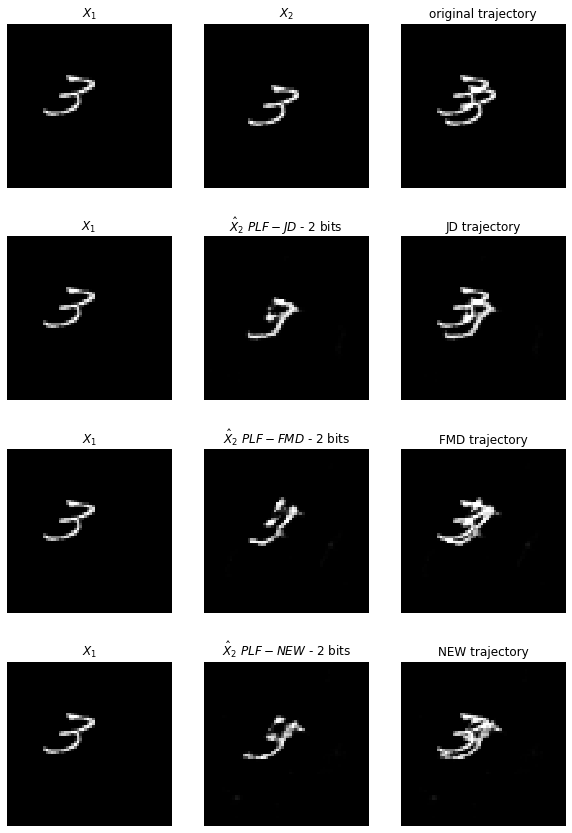

In [498]:

compare_models_2(lambda_ = 0.02 , eps = 2, x = x1, stochastic = True, step = 5)


In [15]:
def plot_video(video):
    
    fig, axarr = plt.subplots(1,8)
    fig.set_size_inches(20, 2)
    frame = np.zeros((64,64), dtype=np.float32)
    
    for i in range(8):
        axarr[i].axis('off')
        axarr[i].imshow(video[i],cmap = 'gray')
        #frame += video[i]
    #frame[frame>1] = 1.
    
    #axarr[8].axis('off')
    #axarr[8].imshow(frame,cmap = 'gray')
        
    plt.show()

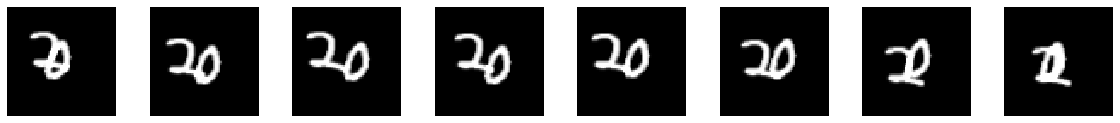

In [131]:
train_loader = MovingMNIST(
                        train=True,
                        data_root='./data/',
                        seq_len=8,
                        image_size=64,
                        deterministic=False,
                        num_digits=2)


train_batch = train_loader[np.random.randint(len(train_loader))]
video = train_batch.squeeze()
plot_video(video)

In [128]:
import torchvision.transforms.functional as TF
from types import SimpleNamespace
import random

In [137]:

angle_range = (-10, 10)
translate_range = ((-5, 5), (-5, 5))
scale_range = (0, 0)
shear_range = (-3, 3)

angle     = np.random.uniform(*angle_range)
translate = (np.random.uniform(*translate_range[0]), 
            np.random.uniform(*translate_range[1]))
scale     = 1 #random.uniform(*scale_range)
shear     = 0 #(0,0)#random.uniform(*shear_range)

data = datasets.MNIST(
            './data/',
            train=True,
            download=True,
            transform=transforms.Compose(
            [transforms.Resize(28),
             transforms.ToTensor()]))

digit, _ = data[0]
img = TF.pad (digit,padding=18)

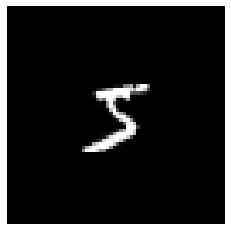

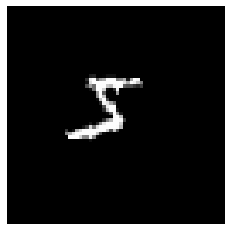

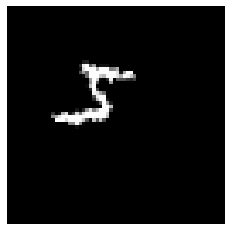

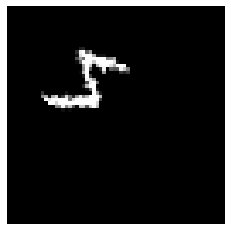

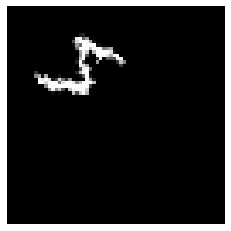

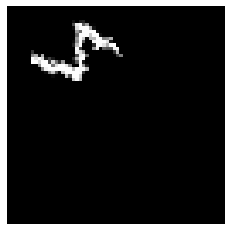

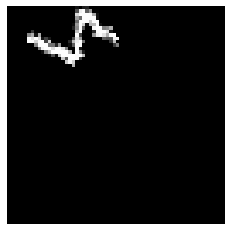

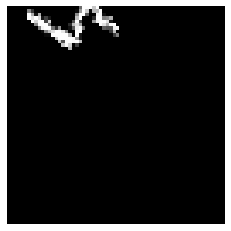

In [138]:
imgs = []
for i in range(8):
    plt.imshow(img.squeeze().numpy(),cmap = 'gray')
    plt.axis('off')
    plt.show()
    img = TF.affine(img, angle, translate, scale, shear)
    


In [56]:
def evaluate_R1eps(metric = 'NEW',lambdas = [0,1,2,3,5,8,10,40,80], bitrates = [2,4,8,12,16]):
    MSE = {'2': [], '4': [], '8': [], '12': [], '16': []}
    PLF = {'2': [], '4': [], '8': [], '12': [], '16': []}
    
    train_loader, test_loader = get_dataloader(data_root='./data/', seq_len=8, batch_size=64, num_digits=1)
    
    encoder = Encoder(dim=12, nc=1, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    decoder = Decoder_Iframe(dim=12).to(device).eval()
    decoder_hat = Decoder_Iframe(dim=12).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))
    mse_loss = nn.MSELoss(reduction = 'sum')
    
    for bitrate in bitrates:
        zdim = bitrate//2
        MSE_list = []
        PLF_list = []

        for l in lambdas:
            l_ = l*1e-3
            JD = FMD = NEW = False
            if metric == 'NEW':
                path = f'./saved_models/{bitrate}/R1-eps|dim_128|z_dim_{zdim}|L_2|'\
                    + f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{l_}|lambdaMSE_1.0'
                discriminator = Discriminator_v3(out_ch=2).to(device)
                discriminator.load_state_dict(torch.load(path + '/discriminator_NEW.pth'))
                NEW = True
            elif metric == 'JD':
                path = f'./saved_models/{bitrate}/R1-eps|dim_128|z_dim_{zdim}|L_2|'\
                    + f'lambdaJD_{l_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
                discriminator = Discriminator_v3(out_ch=2).to(device)
                discriminator.load_state_dict(torch.load(path + '/discriminator_JD.pth'))
                JD = True
            elif metric == 'FMD':
                path = f'./saved_models/{bitrate}/R1-eps|dim_128|z_dim_{zdim}|L_2|'\
                    + f'lambdaJD_0.0|lambdaFMD_{l_}|lambdaNEW_0.0|lambdaMSE_1.0'
                discriminator = Discriminator_v3(out_ch=1).to(device) 
                discriminator.load_state_dict(torch.load(path + '/discriminator_FMD.pth'))
                FMD = True
            print('testing:')
            print(path) 
            ssf = ScaleSpaceFlow_R1eps(num_levels=1, dim=zdim, stochastic=True, quantize_latents=True, L=2).to(device).eval()  
            ssf.motion_encoder.load_state_dict(torch.load(path + '/m_enc.pth'))
            ssf.motion_decoder.load_state_dict(torch.load(path + '/m_dec.pth'))
            ssf.P_encoder.load_state_dict(torch.load(path + '/p_enc.pth'))
            ssf.res_encoder.load_state_dict(torch.load(path + '/r_enc.pth'))
            ssf.res_decoder.load_state_dict(torch.load(path + '/r_dec.pth'))
            
            distance = [] 
            distortion = []
            num_x = 0
            for i, x in enumerate(iter(test_loader)):
                with torch.no_grad():
                    #Get the data
                    x = x.permute(0, 4, 1, 2, 3)
                    x = x.cuda().float()
                    x_cur = x[:,:,1,...]
                    with torch.no_grad():
                        hx = encoder(x[:,:,0,...])[0]
                        x_ref = decoder(hx).detach()
                        x_1_hat = decoder_hat(hx).detach()
                    x_hat = ssf(x_cur, x_ref, x_1_hat)

                    if JD:
                        fake_vid = torch.cat((x_1_hat, x_hat), dim = 1).detach()
                        real_vid = x[:,0,:2,...].detach() 
                        fake_validity = discriminator(fake_vid)
                        real_validity = discriminator(real_vid)

                    if NEW:
                        fake_vid = torch.cat((x_1_hat, x_hat), dim = 1).detach()
                        real_vid_new = torch.cat((x_1_hat, x_cur), dim = 1).detach()
                        new_metric_real_validity = discriminator(real_vid_new)
                        new_metric_fake_validity = discriminator(fake_vid)

                    if FMD:
                        fake_img = x_hat.detach()
                        real_img = x[:,:,1,...].detach()
                        fake_valid_m = discriminator(fake_img)
                        real_valid_m = discriminator(real_img)

                    if JD:
                        distance.append(torch.sum(real_validity) - torch.sum(fake_validity))
                    if NEW:
                        distance.append(torch.sum(new_metric_real_validity) - torch.sum(new_metric_fake_validity))
                    if FMD:
                        distance.append(torch.sum(real_valid_m) - torch.sum(fake_valid_m))

                    distortion.append(mse_loss(x[:,:,1,:,:], x_hat))
                    num_x += len(x)

            distance = torch.Tensor(distance).sum() / num_x
            distortion = torch.Tensor(distortion).sum() / (64*64*num_x)
            MSE_list.append(distortion.item())
            PLF_list.append(distance.item())
            print(distortion.item(),distance.item())
            
        MSE[str(bitrate)] = MSE_list
        PLF[str(bitrate)] = PLF_list
    
    return MSE, PLF

In [495]:
train_mnist = datasets.MNIST('./data','train', transform=transforms.ToTensor())
test_mnist =  datasets.MNIST('./data','test', transform=transforms.ToTensor())
print(train_mnist.data.shape)

torch.Size([60000, 28, 28])


In [491]:
class MoovingMNIST_custom(Dataset):
    """Mooving mnist dataset"""

    def __init__(self, root_dir, partition, transform=None, num_digits=1, seq_len=3, steps = [15,20])
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.seq_len = seq_len
        self.num_digits = num_digits
        self.image_size = 64
        self.digit_size = 28
        self.deterministic = deterministic
        self.steps = steps 
        self.partition = partition
        
        if 'MMNIST/{partition}'len(os.listdir(self.root_dir+'MMNIST/')) > 0:
        #load saved dataset
            pass
        else:
            self.generate_dataset(self) 
            

        
    def generate_dataset(self)
        mnist = datasets.MNIST('./data',train=self.train, transform=self.transform)
        
        
        
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

AttributeError: 'MNIST' object has no attribute 'shape'

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, num_digits=1, seq_len=3, ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.seq_len = seq_len
        self.num_digits = num_digits
        self.image_size = 64
        self.digit_size = 28
        self.deterministic = deterministic
        self.channels = 1
        self.step = step

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class MovingMNIST_custom_step(object):

    """Data Handler that creates Bouncing MNIST dataset on the fly."""

    def __init__(self, train, data_root, seq_len=20, num_digits=1, image_size=64, step=10, deterministic=False):
        path = data_root
        self.seq_len = seq_len
        self.num_digits = num_digits
        self.image_size = image_size
        self.step_length = 0.1
        self.digit_size = 28 #int(image_size/2)
        self.deterministic = deterministic
        self.seed_is_set = False # multi threaded loading
        self.channels = 1
        self.step = step

        self.data = datasets.MNIST(
            path,
            train=train,
            download=True,
            transform=transforms.Compose(
                [transforms.Resize(self.digit_size),
                 transforms.ToTensor()]))

        self.N = len(self.data)

    def set_seed(self, seed):
        if not self.seed_is_set:
            self.seed_is_set = True
            np.random.seed(seed)

    def __len__(self):
        return self.N

    def __getitem__(self, index):
        self.set_seed(index)
        image_size = self.image_size
        digit_size = self.digit_size
        x = np.zeros((self.seq_len,
                      image_size,
                      image_size,
                      self.channels),
                    dtype=np.float32)
        step = self.step
        for n in range(self.num_digits):
            idx = np.random.randint(self.N)
            digit, _ = self.data[idx]

            sx = np.random.randint(image_size-digit_size)
            sy = np.random.randint(image_size-digit_size)
            dx = np.random.randint(-step+1, step)
            dy = np.random.randint(-step+1, step)
            for t in range(self.seq_len):
                dx = np.random.randint(-step+1, step)
                dy = np.random.randint(-step+1, step)
                if sy < 0:
                    sy = 0
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(1, step)
                        dx = np.random.randint(-step+1, step)
                elif sy >= image_size-self.digit_size:
                    sy = image_size-self.digit_size-1
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(-step+1, 0)
                        dx = np.random.randint(-step+1, step)

                if sx < 0:
                    sx = 0
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(1, step)
                        dy = np.random.randint(-step+1, step)
                elif sx >= image_size-self.digit_size:
                    sx = image_size-self.digit_size-1
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(-step+1, 0)
                        dy = np.random.randint(-step+1, step)

                x[t, sy:sy+self.digit_size, sx:sx+self.digit_size, 0] += digit.numpy().squeeze()
                sy += dy
                sx += dx

        x[x>1] = 1.
        return x